# Pengambilan Keputusan Bisnis Toko Online berdasarkan Data Hipotesis dan A/B Testing untuk Meningkatkan Pendapatan

Kamu adalah seorang data analyst di sebuah toko online besar. Kamu bersama tim pemasaran telah menyusun daftar hipotesis untuk membantu meningkatkan pendapatan. 

Tujuan : Memprioritaskan hipotesis, menjalankan A/B testing, dan menganalisis hasilnya.

Kerangka konsep :
   1. Mempersiapkan Data
   2. Memperbaiki data
   3. Memprioritaskan Hipotesis
   4. Analisis A/B Testing
   5. Kesimpulan umum

## Deskripsi data

Dataframe `hypotheses` memuat:
   - `Hypotheses` — Deskripsi singkat tentang hipotesis
   - `Reach` — Jangkauan pengguna, dalam skala satu hingga sepuluh
   - `Impact` — Dampak terhadap pengguna, dalam skala satu hingga sepuluh
   - `Confidence` — Keyakinan pada hipotesis, dalam skala satu sampai sepuluh
   - `Effort` — Sumber daya yang diperlukan untuk menguji hipotesis, dalam skala satu sampai sepuluh. Semakin tinggi nilai Effort, semakin intensif sumber daya pengujiannya

Dataframe `orders_us` memuat:
   - `transactionId` — ID pesanan
   - `visitorId` — ID pengguna yang membuat pesanan
   - `date` — Tanggal dibuatnya pesanan
   - `revenue` — Pendapatan dari pesanan
   - `group` — Kelompok uji (test group) A/B tempat pengguna berada

Dataframe `visits_us` memuat:
   - `date` — Tanggal
   - `group` — Kelompok uji (test group) A/B
   - `visitors` — Jumlah pengunjung pada tanggal yang ditentukan dalam kelompok uji A/B yang ditentukan
   - `visits` —  Jumlah kunjungan pada tanggal yang ditentukan untuk kelompok uji A/B yang ditentukan

## Inisialisasi data

Memuat library

In [202]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import math as mth
import numpy as np
import matplotlib.pyplot as plt

Memuat 3 data

In [203]:
data_hypothesis = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
data_orders = pd.read_csv('/datasets/orders_us.csv')
data_visits = pd.read_csv('/datasets/visits_us.csv')

## Mengenal dan Memperbaiki Data

### Data Hypothesis

In [204]:
data_hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [205]:
data_hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


Merubah semua nama kolom menjadi huruf kecil

In [206]:
data_hypothesis.columns = [i.lower() for i in list(data_hypothesis)]

Mengecek nilai duplikat dan nilai missing data_hypothesis

In [207]:
data_hypothesis.duplicated().sum()

0

In [208]:
report_null_hypothesis = data_hypothesis.isnull().sum().to_frame()
report_null_hypothesis = report_null_hypothesis.rename(columns={0:'missing_values'})
report_null_hypothesis['% of total'] = (report_null_hypothesis['missing_values'] / data_hypothesis.shape[0]).round(2)
report_null_hypothesis.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
hypothesis,0,0.0
reach,0,0.0
impact,0,0.0
confidence,0,0.0
effort,0,0.0


### Data Orders

In [209]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [210]:
data_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


Memodifikasi nama kolom transactionId, dan visitorId lebih efektif

In [211]:
data_orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Mengecek nilai duplikat dan nilai missing data_orders

In [212]:
data_orders.duplicated().sum()

0

In [213]:
report_null_orders = data_orders.isnull().sum().to_frame()
report_null_orders = report_null_orders.rename(columns={0:'missing_values'})
report_null_orders['% of total'] = (report_null_orders['missing_values'] / data_orders.shape[0]).round(2)
report_null_orders.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
transaction_id,0,0.0
visitor_id,0,0.0
date,0,0.0
revenue,0,0.0
group,0,0.0


### Data Visits

In [214]:
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [215]:
data_visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Mengecek nilai duplikat dan nilai missing data_visits

In [216]:
data_visits.duplicated().sum()

0

In [217]:
report_null_visits = data_visits.isnull().sum().to_frame()
report_null_visits = report_null_visits.rename(columns={0:'missing_values'})
report_null_visits['% of total'] = (report_null_visits['missing_values'] / data_visits.shape[0]).round(2)
report_null_visits.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
date,0,0.0
group,0,0.0
visits,0,0.0


## Memprioritaskan Hipotesis

Merumuskan framework ICE pada kolom baru di data_hypothesis

In [218]:
data_hypothesis['ICE'] = data_hypothesis['impact'] * data_hypothesis['confidence'] / data_hypothesis['effort']
data_hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Merumuskan framework RICE pada kolom baru di data_hypothesis

In [219]:
data_hypothesis['RICE'] = data_hypothesis['reach'] * data_hypothesis['impact'] * data_hypothesis['confidence'] / data_hypothesis['effort']
data_hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


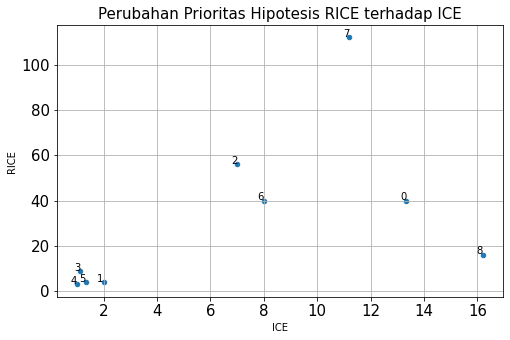

In [220]:
data_hypothesis.plot(x='ICE', y='RICE', kind='scatter', figsize=(8, 5), grid=True, fontsize=15)
plt.title('Perubahan Prioritas Hipotesis RICE terhadap ICE', fontsize=15)
for line in range(0, data_hypothesis.shape[0]):
     plt.text(data_hypothesis.ICE[line], data_hypothesis.RICE[line]+0.2, data_hypothesis.index[line], horizontalalignment='right', size='medium', color='black')
plt.show()

Prioritas Hipotesis:
- Hipothesis 7 merupakan prioritas karena tinggi ICE maupun RICE.
- Sedangkan yang skala sedang untuk di prioritaskan ada hipothesis 0 dan 8, baru di lanjutkan untuk hipothesis 2 dan 6.
- Sedangkan hipothesis 1, 3, 4, dan 5 merupakan yang paling terakhir untuk di prioritaskan.

## Analisis A/B Testing

### Stabilitas Metrik Kumulatif

Langkah awal kita peeking problem terhadap kelompok-kelompok secara terpisah berdasarkan metrik kumulatif grafik.

In [221]:
data_orders['date'] = data_orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
data_visits['date'] = data_visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [222]:
datesGroups = data_orders[['date', 'group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: data_orders[
        np.logical_and(data_orders['date'] <= x['date'], data_orders['group'] == x['group'])
    ].agg({
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'visitor_id': pd.Series.nunique,
            'revenue': 'sum'
            }
        ), axis=1
).sort_values(by=['date', 'group'])
visitsAggregated = datesGroups.apply(
    lambda x: data_visits[
        np.logical_and(data_visits['date'] <= x['date'], data_visits['group'] == x['group'])
    ].agg(
            {
            'date' : 'max',
            'group' : 'max',
            'visits' : 'sum'
            }
        ), axis=1
).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']

Membagi kelompok kumulatif A dan B

In [223]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

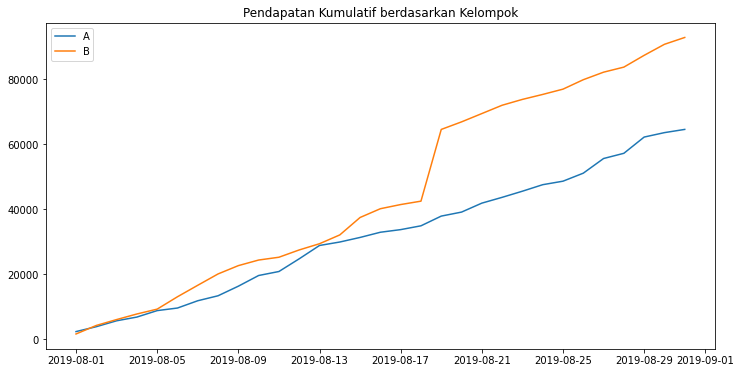

In [224]:
plt.figure(figsize=(12, 6))
plt.title('Pendapatan Kumulatif berdasarkan Kelompok')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.show()

- Setiap kelompok mengalami kenaikan dari hari ke hari
- Kelompok B terlihat adanya kenaikan yang ekstreme
- Mengindikasikan adanya nilai outlier atau anomali

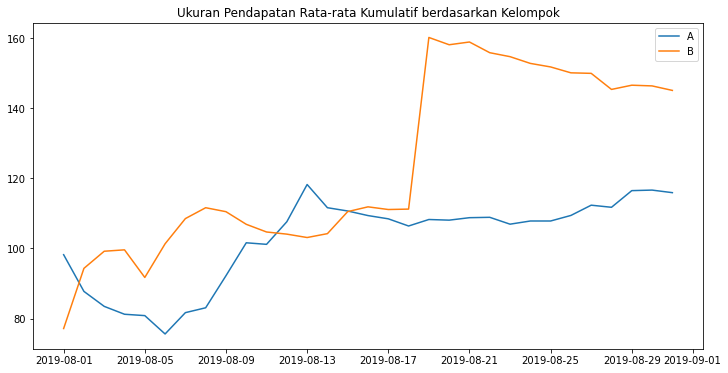

In [225]:
plt.figure(figsize=(12, 6))
plt.title('Ukuran Pendapatan Rata-rata Kumulatif berdasarkan Kelompok')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show()

- Setiap kelompok mengalami kenaikan maupun penurunan secara signifikan
- Kelompok B terlihat adanya lonjakan grafik yang ekstreme di beberapa titik
- Mengindikasikan adanya nilai outlier atau anomali baik kelompok B ataupun A

Membuat kelompok kumulatif pada ukuran pesanan rata-rata

In [226]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

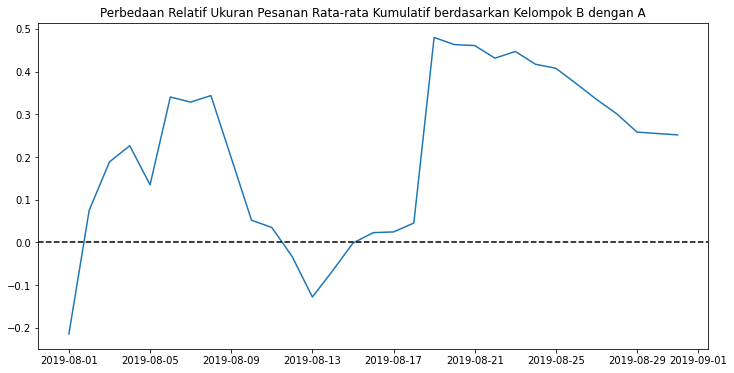

In [227]:
plt.figure(figsize=(12, 6))
plt.title('Perbedaan Relatif Ukuran Pesanan Rata-rata Kumulatif berdasarkan Kelompok B dengan A')
plt.plot(mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Lonjakan yang terpaut jauh dari satu titik dengan yang lain ini mengindikasikan adanya nilai outlier

In [228]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

(18109.0, 18139.0, 0.0, 0.05)

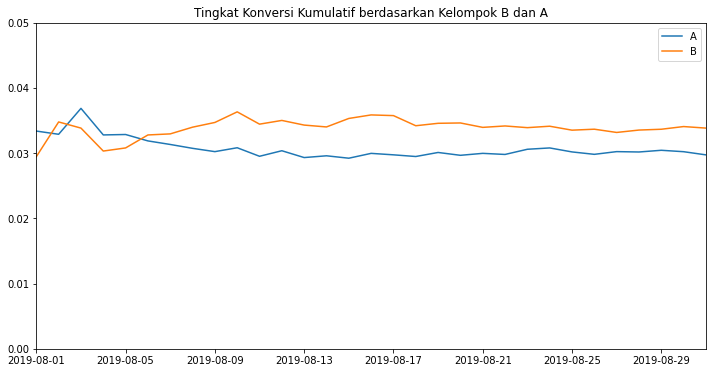

In [229]:
plt.figure(figsize=(12, 6))
plt.title('Tingkat Konversi Kumulatif berdasarkan Kelompok B dan A')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), 0, 0.05])

- Setiap kelompok mengalami kestabilan dengan kelompok B yang lebih baik
- Mengindikasikan adanya nilai outlier atau anomali baik kelompok B ataupun A

In [230]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

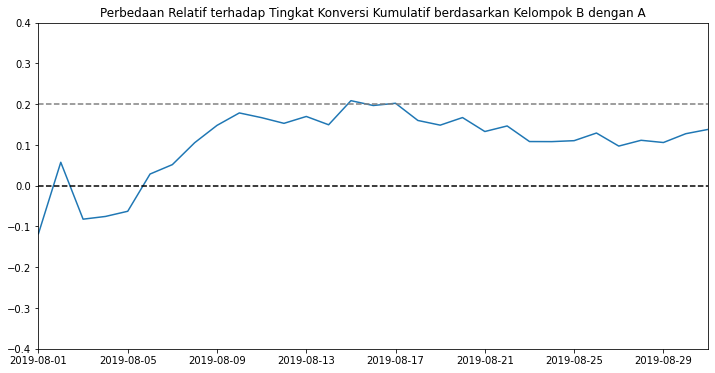

In [231]:
plt.figure(figsize=(12, 6))
plt.title('Perbedaan Relatif terhadap Tingkat Konversi Kumulatif berdasarkan Kelompok B dengan A')
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), -0.4, 0.4])
plt.show()

Masih belum terlihat adanya perbedaan yang signifikan dari pengujian awal hingga saat ini, kelompok B masih memimpin. Tingkat konversinya juga cukup stabil

### Analisis Nilai Outlier

Mengidentifikasi nilai outlier

In [232]:
ordersByUsers = (
    data_orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers.columns = ['visitor_id', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


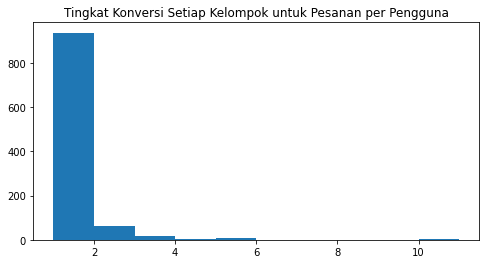

In [233]:
plt.figure(figsize=(8, 4))
plt.title('Tingkat Konversi Setiap Kelompok untuk Pesanan per Pengguna')
plt.hist(ordersByUsers['orders'])
plt.show()

Grafik menunjukkan pesanan 1 - 3 cukup banyak. Sedangkan nilai lain seperti 4, 6, dan 10 sebagian besar pesanannya berukuran lebih kecil.

In [234]:
x_values = pd.Series(range(0,len(ordersByUsers)))

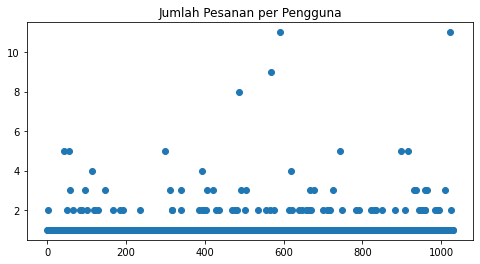

In [235]:
plt.figure(figsize=(8, 4))
plt.title('Jumlah Pesanan per Pengguna')
plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

In [236]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Dengan demikian, kita bisa menetapkan 2 atau 3 pesanan per pengguna sebagai batas bawah jumlah pesanan sekaligus untuk memfilter anomali.

In [237]:
data_orders.sort_values(by='revenue', ascending=False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B
1196,3936777065,2108080724,2019-08-15,3120.1,B
858,192721366,1316129916,2019-08-27,1450.2,A
1136,666610489,1307669133,2019-08-13,1425.8,A
744,3668308183,888512513,2019-08-27,1335.6,B
662,1811671147,4266935830,2019-08-29,1220.2,A
682,1216533772,4266935830,2019-08-29,1220.2,B
743,3603576309,4133034833,2019-08-09,1050.0,A
1103,1348774318,1164614297,2019-08-12,1025.8,A
1099,316924019,148427295,2019-08-12,1015.9,A


In [238]:
x_values = pd.Series(range(0,len(data_orders['revenue'])))

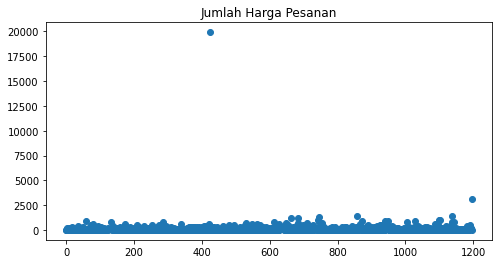

In [239]:
plt.figure(figsize=(8, 4))
plt.title('Jumlah Harga Pesanan')
plt.scatter(x_values, data_orders['revenue']) 
plt.show()

In [240]:
print(np.percentile(data_orders['revenue'], [95, 99]))

[435.54  900.904]


Berdasarkan grafik di atas dan hasil persentil, kita bisa menetapkan limit untuk pesanan yang tidak normal, yakni 435 sampai 900 dolar

### Penentuan Signifikansi Statistik

Mengolah data order dan visits untuk mencari nilai signifikansi

In [241]:
ordersByUsersA = data_orders[data_orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']
ordersByUsersB = data_orders[data_orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders']

In [242]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum() -
    len(ordersByUsersA['orders'])), name='orders')],axis=0
)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum() -
    len(ordersByUsersB['orders'])), name='orders')],axis=0
)

In [243]:
print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


Baris pertama dari output yang dihasilkan memberi kita nilai p sebesar 0,0168, yang mana lebih kecil dari 0,05. Analisis data mentah ini mengindikasikan, kita menolak hipotesis nol karena adanya perbedaan yang signifikan secara statistik dalam konversi antar kelompok. Dan perolehan konversi relatifnya dari kelompok B dengan A adalah 13,8% 

In [244]:
print('{0:.3f}'.format(st.mannwhitneyu(data_orders[data_orders['group']=='A']['revenue'],
                                        data_orders[data_orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(data_orders[data_orders['group']=='B']['revenue'].mean() /
                       data_orders[data_orders['group']=='A']['revenue'].mean()-1))

0.692
0.252


Nilai p 0,692 jauh lebih tinggi dari 0,05, ini menyimpulkan bahwa tidak ada perbedaan yang signifikan secara statistik dalam hal ukuran pesanan rata-rata antar kelompok. Dengan perbedaan relatifnya sebesar 25% . 

In [245]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id']], axis = 0)
usersWithExpensiveOrders = data_orders[data_orders['revenue'] > 435]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders],
                          axis = 0).drop_duplicates().sort_values()
abnormalUsers.head(10)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
684     358944393
648     382846391
1189    393266494
68      457167155
68      611059232
Name: visitor_id, dtype: int64

In [246]:
abnormalUsers.shape

(75,)

Secara total, kita memiliki 75 pengguna yang tidak wajar. dan telah kita filter data duplikat untuk user anomali tersebut

Sekarang kita coba kembali untuk menghitung data yang telah di filter

In [247]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0)

In [248]:
print("{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.01418
0.171


Ada perubahan walaupun sedikit untuk perolehan nilai p di 0,014 dan perolehan sample B yang lebih baik daripada sample A. Ini mengindikasikan, kita tidak bisa menolak hipotesis nol karena tidak ditemukannya perbedaan yang signifikan secara statistik dalam konversi antar kelompok. Dan konversi rata-rata kumulasi relatifnya dari kelompok B dengan A adalah 17,1% 

In [249]:
print('{0:.3f}'.format(st.mannwhitneyu(
    data_orders[np.logical_and(
        data_orders['group']=='A',
        np.logical_not(data_orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    data_orders[np.logical_and(
        data_orders['group']=='B',
        np.logical_not(data_orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    data_orders[np.logical_and(data_orders['group']=='B',
                               np.logical_not(data_orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() /
    data_orders[np.logical_and(data_orders['group']=='A',
                               np.logical_not(data_orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.750
-0.027


Setelah data yang kita miliki difilter dari anomali, hasil untuk nilai p meningkat menjadi 0,75 dan disimpulkan kita tidak bisa menolak h0 karena lebih besar dari 0,05 yang berarti pula tidak adanya perbedaan yang signifikan secara statistik dalam ukuran pesanan rata-rata antar kelompok baik B maupun A, tetapi sekarang perbedaan antar segmen mengalami penurunan dari 25% menjadi 1% yang mengindikasikan kelompok A memiliki ukuran pesanan rata-rata kumulatifnya lebih besar dari B. 

## Kesimpulan Umum

Fakta-fakta yang bisa di ambil dari hasil uji analisis A/B Testing :

- Baik data mentah maupun data yang telah difilter, keduanya tidak menunjukkan perbedaan yang signifikan secara statistik dalam hal konversi antar kelompok.
- Berbeda dalam hal ukuran pesanan rata-rata antar kelompok baik dari data mentah maupun data yang telah difilter, keduanya  menunjukkan perbedaan yang signifikan secara statistik.
- Grafik yang menunjukkan perbedaan konversi antar kelompok menunjukkan bahwa hasil kelompok B lebih baik dan adanya peningkatan di awal lalu stabil hingga akhir.
- Grafik yang menunjukkan perbedaan ukuran pesanan rata-rata antar kelompok menunjukkan bahwa hasil kelompok B naik turun dan mulai terjadi penurunan grafik dari hari ke hari, akan tetapi saat ini nilainya 25% lebih tinggi daripada kelompok A.

Berdasarkan fakta diatas dan hasil uji, dapat disimpulkan bahwa tidak di temukannya perbedaan yang signifikan secara statistik dalam ukuran pesanan rata-rata antar kelompok dengan nilai p 0,75. Berdasarkan hasil temuan juga merepresentasikan kita untuk menghentikan pengujian, dan mempertimbangkan salah satu kelompok sebagai kelompok unggul yaitu kelompok A yang memiliki nilai lebih baik daripada kelompok B. Dimana untuk hasil filter kepada nilai outlier atau anomali yang berhasil di eliminasi memiliki perbedaan konversi dari 25% menjadi 2%.